In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from skimage.measure import compare_ssim
from skimage.metrics import structural_similarity as ssim
import imutils
import skimage

In [25]:
topic = "cig"
img_fold = "D:/note/image_contrast/img/"
img1_name = img_fold + topic + "1.jpg"
img2_name = img_fold + topic + "2.jpg"
constrast_name = img_fold + topic + "c.jpg"
result_name = img_fold + topic + "r.jpg"
img_source = cv2.imread(img2_name)
img1 = cv2.imread(img1_name,0)
img2 = cv2.imread(img2_name,0)

### warp

In [26]:
surf = cv2.xfeatures2d.SURF_create(1000, upright=True)  #param
kp1, des1 = surf.detectAndCompute(img1, None)
imgA = cv2.drawKeypoints(img1, kp1, None, (255, 0, 0), 4)

kp2, des2 = surf.detectAndCompute(img2, None)
imgB = cv2.drawKeypoints(img2, kp2, None, (255, 0, 0), 4)

In [27]:
print(len(kp1),len(kp2))

232 226


In [5]:
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
GOOD_POINTS_LIMITED = 0.99
goodPoints =[]
for i in range(len(matches)-1):
    if matches[i].distance < GOOD_POINTS_LIMITED * matches[i+1].distance:
        goodPoints.append(matches[i])

In [6]:
print(len(matches))

232


In [7]:
contrast = cv2.drawMatches(img1, kp1, img2, kp2, matches[:4], None, flags=2)
cv2.imwrite(constrast_name,contrast)  # 输出中间过程的对比图片

True

In [8]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:4]]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:4]]).reshape(-1, 1, 2)
# 定义对应的点
points1 = np.float32(src_pts[:,0])
points2 = np.float32(dst_pts[:,0])
M = cv2.getPerspectiveTransform(points1, points2)
img1_warp = cv2.warpPerspective(img1,M,(img2.shape[1],img2.shape[0]))

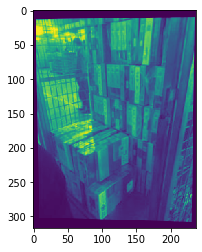

In [9]:
plt.imshow(img1_warp)

### crop

In [10]:
x = np.sum(img1_warp,axis=0)
trim_bx= np.trim_zeros(x,'b')
trim_x= np.trim_zeros(x)
edg_l_x = len(trim_bx) - len(trim_x) + 10
edg_r_x = len(x) - len(trim_bx) + 10

In [11]:
y = np.sum(img1_warp,axis=1)
trim_by= np.trim_zeros(y,'b')
trim_y= np.trim_zeros(y)
edg_t_y = len(trim_by) - len(trim_y) + 10
edg_b_y = len(y) - len(trim_by) + 10

In [12]:
img1_c = img1_warp[edg_t_y:-edg_b_y,edg_l_x:-edg_r_x]
cv2.imwrite(img_fold + 'crop1.jpg',img1_c)
img2_c = img2[edg_t_y:-edg_b_y,edg_l_x:-edg_r_x]
cv2.imwrite(img_fold + 'crop2.jpg',img2_c)

True

### contrast

In [13]:
# 中值滤波
grayA = cv2.medianBlur(img1_c,5)
grayB = cv2.medianBlur(img2_c,5)

In [14]:
(score, diff) = ssim(grayA, grayB, full=True, gaussian_weights =True, sigma = 20)
diff = (diff * 255).astype("uint8")

In [15]:
_,thresh = cv2.threshold(diff, 10, 255, cv2.THRESH_BINARY_INV)  #param

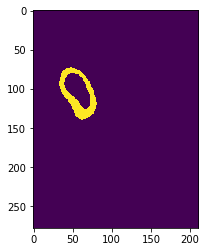

In [16]:
plt.imshow(thresh)

In [17]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [18]:
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(img_source, (x, y), (x + w, y + h), (0, 0, 255), 2)

In [19]:
cv2.imwrite(result_name,img_source)

True